In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
import numpy as np

In [2]:
#data
df_build = pd.read_csv("Chauderon_Buildings (1).csv")
df_TR = pd.read_csv("locationsTF.csv")
bus_geodata = pd.read_excel("632_0_PP.xlsx",sheet_name="bus_geodata").drop(columns="coords").rename(columns={"Unnamed: 0":"bus_id"})

In [3]:
#node coords for NN
kdtree_bus = KDTree(bus_geodata[["x","y"]].values)

In [4]:
# Liking points to transformers with data from the dataset
useful_build = df_build[["energy_el_kWh_y","roof_annual_irr_kWh_y","facade_annual_irr_kWh_y","transformer"]]
loc_TR = df_TR[["id","x","y"]]
df_TR_final = pd.merge(loc_TR, useful_build.groupby("transformer").sum().reset_index(), left_on="id", right_on="transformer", how="outer")
df_TR_final["avg_el_kW"] = df_TR_final["energy_el_kWh_y"]/8760
df_TR_final["avg_roof_irr_kW"] = df_TR_final["roof_annual_irr_kWh_y"]/8760
df_TR_final["avg_facade_irr_kW"] = df_TR_final["facade_annual_irr_kWh_y"]/8760
df_TR_final.head(1)

,id,x,y,transformer,energy_el_kWh_y,roof_annual_irr_kWh_y,facade_annual_irr_kWh_y,avg_el_kW,avg_roof_irr_kW,avg_facade_irr_kW
0,3185,2.536696e+06,1.153091e+06,3185,1882136.7,24989958,17724297,214.855788,2852.734932,2023.321575


In [5]:
#Linking points to their centroid
loc_build = df_build[["id_building","x","y","transformer"]]
centroid_build = loc_build.groupby("transformer").mean().reset_index()

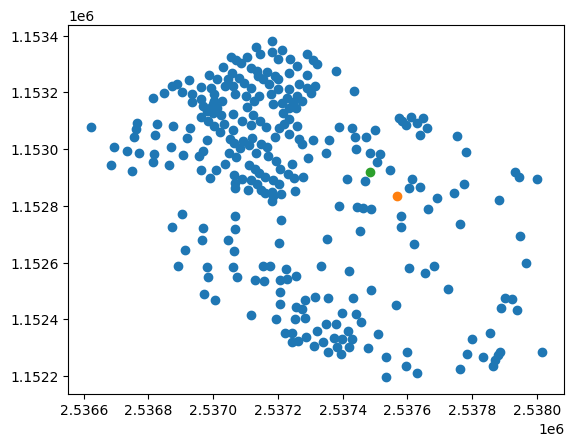

In [6]:
plt.scatter(loc_build.x,loc_build.y)
plt.scatter(loc_TR[loc_TR.id==3244].x,loc_TR[loc_TR.id==3244].y)
plt.scatter(centroid_build[centroid_build.transformer==3244].x,centroid_build[centroid_build.transformer==3244].y)

### Other Method : KNN clustering

With the first 2 techniques used, we only had 8 clusters, which doesn't match reality and/or data from swiss PDG that have 98 buses with demand. Therefore a KNN approach is used to get the clusters corresponding to the actual number of clusters

In [7]:
# Step 1: Create a new column to keep track of whether a point is close to any bus
def is_within_distance(point, buses, max_distance):
    for _, bus in buses.iterrows():
        distance = np.sqrt((point['x'] - bus['x']) ** 2 + (point['y'] - bus['y']) ** 2)
        if distance <= max_distance:
            return True
    return False

In [8]:
# Filter out all buildings that are more than "max_distance" away from one grid node.
KNN_build = loc_build.copy()
max_distance = 200  # 100 meters
KNN_build['close_to_bus'] = KNN_build.apply(is_within_distance, buses=bus_geodata, max_distance=max_distance, axis=1)
KNN_build = KNN_build[KNN_build['close_to_bus']].drop(columns='close_to_bus')

In [9]:
# Use KNN networks to cluster Buildings together
# Use of 98 clusters because in the original data 98 Buses had demand. --> allows the data to be in the same range
kmeans = KMeans(n_clusters=98, random_state=0)

KNN_build['cluster_id'] = kmeans.fit_predict(KNN_build[["x","y"]].values)

centroids = kmeans.cluster_centers_
KNN_df = pd.DataFrame(centroids, columns=['x', 'y']) #Give location of the centroids of the clusters
KNN_df['cluster_id'] = KNN_df.index #create an id for each clusters

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [10]:
# Step 2: Query the closest node for each point

# searching closest point for transformers
_, indices_tr = kdtree_bus.query(df_TR_final[['x', 'y']].values)
df_TR_final['closest_node_id'] = bus_geodata.iloc[indices_tr].bus_id.values

# searching closest point for centroids
_, indices_centr = kdtree_bus.query(centroid_build[['x', 'y']].values)
centroid_build['closest_node_id'] = bus_geodata.iloc[indices_centr].bus_id.values

# searching closest point for KNN
_, indices_KNN = kdtree_bus.query(KNN_df[['x', 'y']].values)
KNN_df['closest_node_id'] = bus_geodata.iloc[indices_KNN].bus_id.values

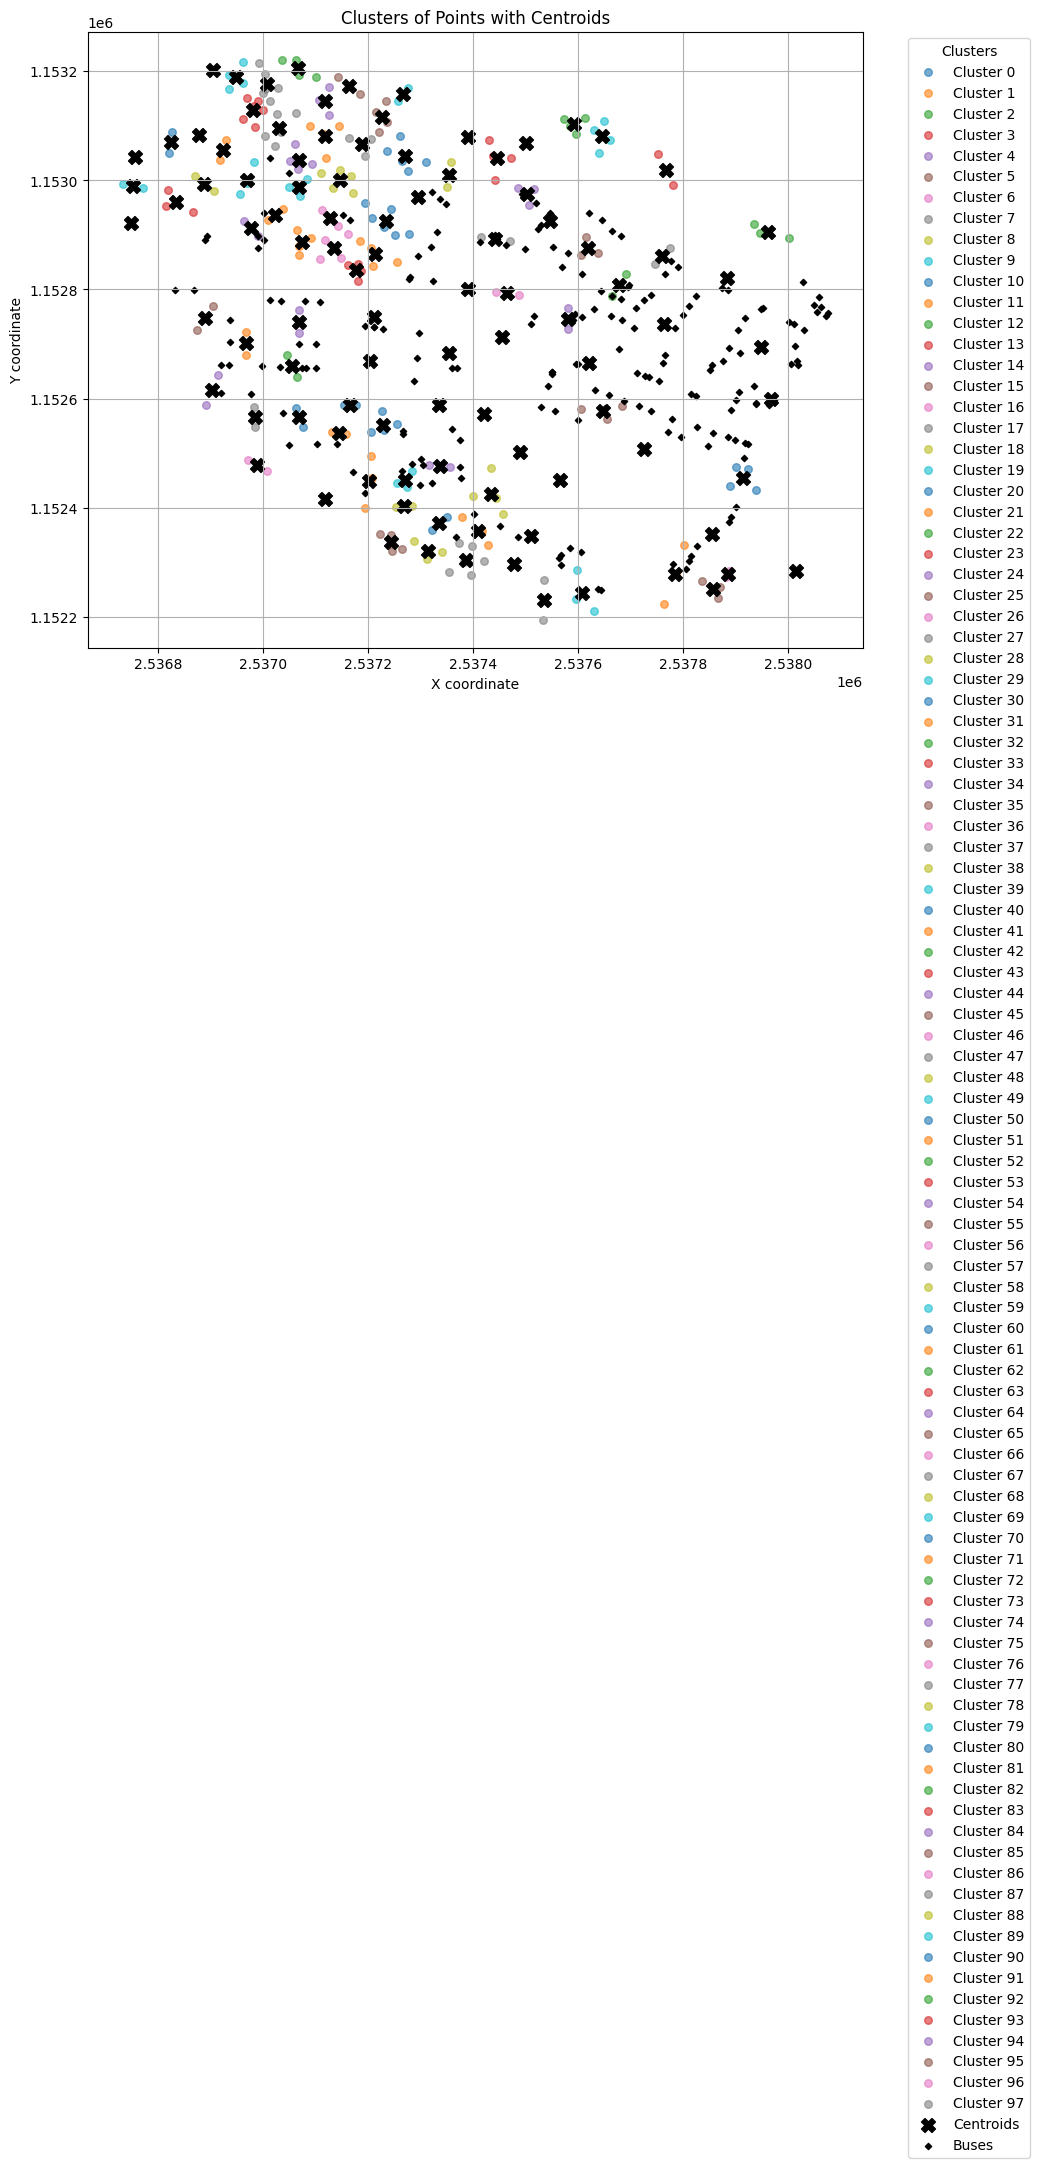

In [11]:
# Plot clusters 
plt.figure(figsize=(10, 8))

for cluster_id in KNN_df['cluster_id'].values:
    cluster_points = KNN_build[KNN_build['cluster_id'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster_id}', s=30, alpha=0.6)

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=100, label='Centroids')
plt.scatter(bus_geodata.x, bus_geodata.y, c='black', marker='D', s=10, label='Buses')


# Customizing the plot
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Clusters of Points with Centroids')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Clusters")  # Place the legend outside the plot
plt.grid(True)
plt.show()

In [12]:
# Map the cluster_id to grid_node to apply in on each building:
Building_data_KNN = KNN_build.merge(KNN_df[['cluster_id', 'closest_node_id']],on='cluster_id', how='left').rename(columns={'closest_node_id': 'grid_node'}).drop(columns="transformer")
#Map the Id_building to Hub to get the name of the building in that dataset:
Building_data_KNN = Building_data_KNN.merge(df_build[['id_building','Hub']],on='id_building', how='left')

In [13]:
Building_data_KNN

,id_building,x,y,cluster_id,grid_node,Hub
0,10,2537763.934,1152736.286,52,142,Building1
1,11,2537745.695,1152845.777,67,159,Building2
2,12,2537774.918,1152876.028,67,159,Building3
3,120,2537883.024,1152820.996,30,104,Building4
4,141,2537947.311,1152693.849,66,111,Building5
...,...,...,...,...,...,...
239,1903852,2537683.444,1152587.086,25,166,Building296
240,1903854,2537690.581,1152827.891,2,149,Building297
241,1903864,2537655.394,1152562.112,25,166,Building298
242,1903870,2537661.060,1153072.818,9,72,Building299


In [ ]:
Building_data_KNN.to_csv("building_data_KNN.csv",index=False)